In [2]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
#import multiprocess as mp

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-06 00:55:11.511636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Inicialización
#RANDOM_SEED = 42

#Separacion del texto en palabras (como maximo)
MAX_LEN = 40

#Introduccion en paquetes (batch_size) al modelo
BATCH_SIZE = 16

#Numero de salida del modelo (P,N,NEU)
NCLASSES = 3

#Semilla aleatoria y aleatoria para pytorch
#np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
df = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train_dev/train_dev_all.csv')
print(df.shape)
print (df.head())

(7234, 2)
                                                text sentiment
0  @dianalaa32 Es una escena de uno de los docume...         P
1  Qué feo es tener que terminar con alguien; y m...         N
2  Oído en McDonalds "el mejor mannequin challeng...         N
3  Tengo que aceptar que me esta hundiendo el con...       NEU
4  Mmm no quiero hacer spoiler pero hoy va a ver ...       NEU


In [5]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [6]:
df.sentiment.replace("P" , 2 , inplace = True)
df.sentiment.replace("N" , 0 , inplace = True)
df.sentiment.replace("NEU" , 1, inplace = True)
df.head()

,text,sentiment
0,@dianalaa32 Es una escena de uno de los docume...,2
1,Qué feo es tener que terminar con alguien; y m...,0
2,"Oído en McDonalds ""el mejor mannequin challeng...",0
3,Tengo que aceptar que me esta hundiendo el con...,1
4,Mmm no quiero hacer spoiler pero hoy va a ver ...,1


In [7]:
df['label'] = df['sentiment']
df.drop('sentiment', axis=1, inplace=True)
print(df)

                                                   text  label
0     @dianalaa32 Es una escena de uno de los docume...      2
1     Qué feo es tener que terminar con alguien; y m...      0
2     Oído en McDonalds "el mejor mannequin challeng...      0
3     Tengo que aceptar que me esta hundiendo el con...      1
4     Mmm no quiero hacer spoiler pero hoy va a ver ...      1
...                                                 ...    ...
7229  @sebatramp Acá también, Seba ???? Para peor el...      0
7230  @Phoyu_Agustina no soy hack pero es imposible ...      1
7231  Nadie te vende un The Last of Us Remastered po...      0
7232  Me propuse dejar las redes, las salidas &amp; ...      1
7233  @irenichus siii! Voy como en media hora. Me va...      2

[7234 rows x 2 columns]


Text(0.5, 0.98, 'Histogram number of words in text')

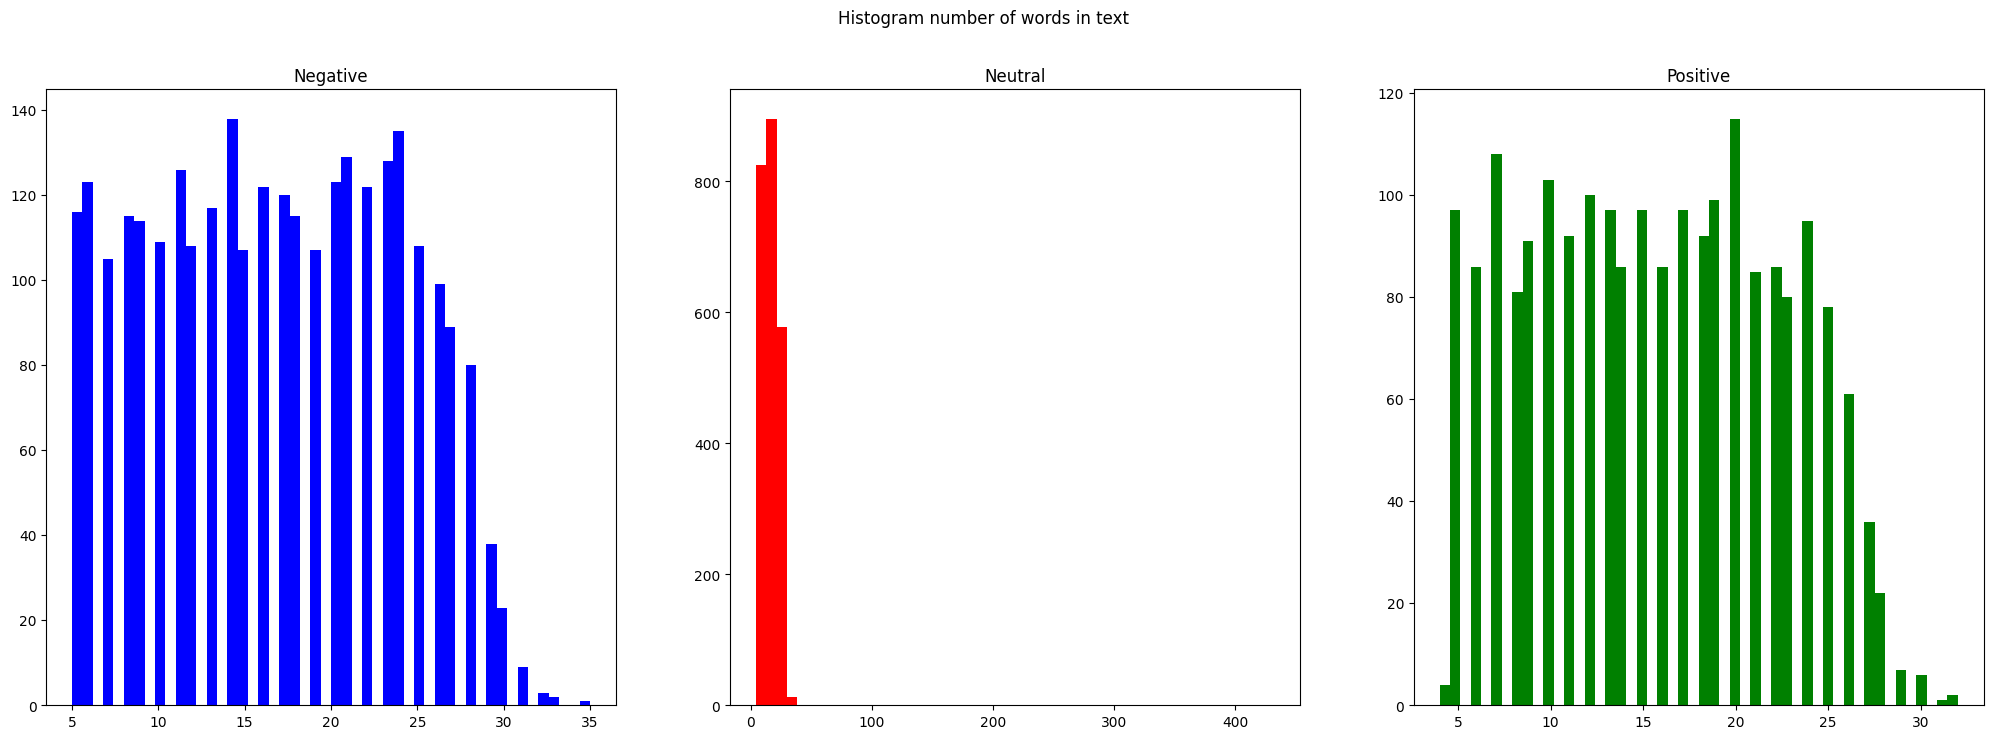

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,8))

ax1.hist(df[df['label'] == 0]['text'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative')

ax2.hist(df[df['label'] == 1]['text'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Neutral')

ax3.hist(df[df['label'] == 2]['text'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Positive')


f.suptitle('Histogram number of words in text')

In [9]:
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))>=25)
print('Number of sentences which contain more than 25 words: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))>=28)
print('Number of sentences which contain more than 28 words: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))==35)
print('Number of sentences which contain 35 words: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')

#Elegimos max_len=30

Number of sentences which contain more than 20 words:  2537
 
Number of sentences which contain more than 25 words:  973
 
Number of sentences which contain more than 28 words:  272
 
Number of sentences which contain more than 30 words:  61
 
Number of sentences which contain 35 words:  1
 


In [10]:
df['review'] = df['text']
df.drop('text', axis=1, inplace=True)
print(df)

      label                                             review
0         2  @dianalaa32 Es una escena de uno de los docume...
1         0  Qué feo es tener que terminar con alguien; y m...
2         0  Oído en McDonalds "el mejor mannequin challeng...
3         1  Tengo que aceptar que me esta hundiendo el con...
4         1  Mmm no quiero hacer spoiler pero hoy va a ver ...
...     ...                                                ...
7229      0  @sebatramp Acá también, Seba ???? Para peor el...
7230      1  @Phoyu_Agustina no soy hack pero es imposible ...
7231      0  Nadie te vende un The Last of Us Remastered po...
7232      1  Me propuse dejar las redes, las salidas &amp; ...
7233      2  @irenichus siii! Voy como en media hora. Me va...

[7234 rows x 2 columns]


In [11]:
#Tokenización:
#Tokenizer: Coje el texto en bruto y lo tokeniza

#Modelo BERT base (Preentrenado 10M de parametros)
#Cased: Entiende mayusculas y minusculas
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
# CREACIÓN DATASET

class TrainDataset(Dataset):
#Iniciamos la clase con estos parametros
  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

#Estructura de pytorch (longitud del texto) necesario siempre
  def __len__(self):
    return len(self.reviews)
      
    
#Funcion que utilizara pytorch para crear leer y crear paquetes aleatorios de 16 datos
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    #Encode_plus: Añade los tokens especiales (CLS SEP + PAD)
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        #Truncation: Recorta la frase si sobrepasa el max_len
        truncation = True,
        #Add_special_tokens: Añade los tokens especiales
        add_special_tokens = True,
        return_token_type_ids = False,
        #Pad_to_max_length: Cuando max_len sobrepase la frase añade tokens vacios
        pad_to_max_length = True,
        #Añade attention_mask para que el modelo solo coja los tokens CLS SEP
        return_attention_mask = True,
        return_tensors = 'pt'
        )
      

    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      } 

In [13]:
# Data loader (funcion que lee los datos)


def data_loader(df, tokenizer, max_len, batch_size):
  dataset = TrainDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)
#num_workers, de los paquetes (16) entrenara 4 en paralelo (agilizar el entrenamiento)

In [14]:
df_train, df_test = train_test_split(df, test_size = 0.2)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
# EL MODELO

#Creamos una clase para llamarla y crear el modelo (pytorch nn.Module= red neuronal con sus caracteristicas)
class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    
    #Primer elemento del modelo: Bert entrenado
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    
    #Eliminamos el overfitting: Apagamos el 30% neuronas para hacerla mas robusta
    self.drop = nn.Dropout(p=0.3)
    
    #Capa lineal de neuronas:
    #Self.bert.config.hidden_size (neuronas de entrada = Salida de bert)
    #N_classes: Salida de la capa lineal de neuronas = 3 (sentimientos)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  
  #Funcion para conectar Bert con red neuronal lineal y los datos de entrada
  def forward(self, input_ids, attention_mask):
    
    #Definimos los datos que pasamos por BERT:
    #_, porque solo nos interesa la codificación de los tokens del texto (el primero no)
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
        return_dict=False
    )
    
    #Pasamos el Bert por drop_out
    drop_output = self.drop(cls_output)
    #Pasamos el drop_out por la salida de la red neuronal
    output = self.linear(drop_output)
    return output

In [16]:
#Creamos el modelo

model = BERTSentimentClassifier(NCLASSES)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
#Miramos el modelo antes de entrenarlo
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [18]:
# ENTRENAMIENTO

#Epochs = iteraciones de entrenamiento
EPOCHS = 5

#Algoritmo Adam = parecido al descenso del gradiente
#lr = tasa de aprendizaje 
#correct_bias= Que no modifique los parametros del aprendizaje
#Total_setps= Numero totales de iteraciones de entrenamiento
#scheduler= que la tasa de aprendizaje lr vaya disminuyendo con el tiempo
#Warmup_steps= Que en la itteracion 0 empiece a disminuir la tasa de aprendizaje (optimiza el entrenamiento)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)
#loss_fn= Funcion de error que quiero minimizar

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  #Cojemos un batch de 16 del data_loader
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
   
   #Calcula las predicciones: de las dos salidas del modelos cual es maxima
    _, preds = torch.max(outputs, dim=1)
    #Perdida de la prediccion (entre salida del modelo y etiqueta original)
    loss = loss_fn(outputs, labels)
    #Calculamos la precisión (suma acumulada de todas prediciones = labels)
    correct_predictions += torch.sum(preds == labels)
    #Agregamos el error calculado a la lista
    losses.append(loss.item())
    #El error calculado lo pasamos al modelo para modificar los pesos (backpropagation)
    loss.backward()
    #Evitamos que el gradiente descendiente aumente demasiado (se estanque el entrenamiento)
    #Lo recortamos si soprepasa el -1 o 1
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    #Actualizamos pesos, tasa de entrenamiento
    optimizer.step()
    scheduler.step()
    #Reseteamos los gradientes para la siguiente iteracion
    optimizer.zero_grad()
  #Pedimos que nos devuelva la precision y el valor promedio del error
  return correct_predictions.double()/n_examples, np.mean(losses)

#Funcion para evaluar el modelo a la vez
#Congelamos el modelo sin actualizarle los parametros para evaluarlo
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  #torch.no_grad = que no modifique ningun parametro del modelo
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  #Devuelve lo mismo pero para la evaluación
  return correct_predictions.double()/n_examples, np.mean(losses)

In [20]:
# Entrenamiento!!!

for epoch in range(EPOCHS):
    print('Epoch {} de {}'.format(epoch+1, EPOCHS))
    print('------------------')
    #Que nos calcule la funcion del entrenamiento de arriba con sus parametros
    train_acc, train_loss = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
    #Que nos calcule la funcion de validacion de arriba con sus parametros
    test_acc, test_loss = eval_model(
        model, test_data_loader, loss_fn, device, len(df_test)
  )
    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
    print('')

Epoch 1 de 5
------------------


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TrainDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 